# Load raw dataset
A medium-sized dataset is provided (rather than 12 GB full dataset as is in AWS) for data wrangling in the spark cluster of IBM Watson Studio. 

**Note:** 
IBM Watson Studio (lite version) is not free to use and has limited use time monthly. Also, Udacity does not provide AWS credit. So I complete this project on my local computer. The code for loding data from cloud is not used but I provide the code here for reference in the future.


In [ ]:
# Load raw data to spark
# IBM Watson Studio is not free to use unlimited even for the lite version, I complete this project locally

import ibmos2spark, os
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-b314834d-5443-4359-8efa-88fb1ca94789',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'NfS0KqvIB-QZO6PoO6p1UYPdzthvM2t3mOeNGUatbbnC'
}

configuration_name = 'os_c4ce378e6d4243b4bee4d7f946ea0bff_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-crgpbxoft3rjye'))
df_data_1.take(5)

***The project work starts from here.***

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row, Window
import builtins as p
from pyspark.sql.functions import col, udf, sum, when, avg, stddev, max, trim, lower, count, isnan
from pyspark.sql.types import IntegerType, StringType
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

# create a spark session
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json('medium-sparkify-event-data.json')
df_data_1.take(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/23 08:48:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Data cleanning 
In this section, data cleaning is completed including checking size of dataset, columns, invalid or missing data, drop duplicates, exploratory visualization, categorical data processing, and so forth. 

In [4]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [2]:
df_data_1.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [6]:
# check the size of the dataset
print((df_data_1.count(), len(df_data_1.columns)))

(543705, 18)


In [4]:
df_pandas = df_data_1.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [5]:
# check the unique values of the specific columns
df_pandas.auth.unique(), df_pandas.level.unique(), df_pandas.method.unique(), df_pandas.page.unique(), df_pandas.status.unique()

(array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object),
 array(['free', 'paid'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Logout', 'Home', 'Login', 'Downgrade',
        'Add to Playlist', 'Roll Advert', 'Thumbs Up', 'Help',
        'Thumbs Down', 'Add Friend', 'About', 'Settings', 'Save Settings',
        'Upgrade', 'Submit Downgrade', 'Cancel',
        'Cancellation Confirmation', 'Submit Upgrade', 'Error', 'Register',
        'Submit Registration'], dtype=object),
 array([200, 307, 404]))

In [9]:
# count the number of unique values
df_data_1.select('artist').distinct().count(), df_data_1.select('song').distinct().count(), df_data_1.select('itemInSession').distinct().count(), df_data_1.select('location').distinct().count(), \
 df_data_1.select('sessionId').distinct().count(), df_data_1.select('userId').distinct().count()

(21248, 80293, 1006, 193, 4590, 449)

In [11]:
# count null users
df_pandas[df_pandas.userId == '']['userId'].count(), df_pandas[df_pandas.userId == '']['sessionId'].count()

(15700, 15700)

In [4]:
# remove the records with null users
df_data_1 = df_data_1.filter(df_data_1.userId != '')
df_data_1.filter(df_data_1.userId == '').count(), df_data_1.filter(df_data_1.sessionId == '').count()

(0, 0)

In [5]:
df_pandas = df_data_1.toPandas()
df_data_1.select('artist').distinct().count(), df_data_1.select('song').distinct().count(), df_data_1.select('itemInSession').distinct().count(), df_data_1.select('location').distinct().count(), \
 df_data_1.select('sessionId').distinct().count(), df_data_1.select('userId').distinct().count()

(21248, 80293, 1006, 192, 4470, 448)

In [6]:
df_pandas.auth.unique(), df_pandas.level.unique(), df_pandas.method.unique(), df_pandas.page.unique(), df_pandas.status.unique()

(array(['Logged In', 'Cancelled'], dtype=object),
 array(['free', 'paid'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Logout', 'Home', 'Downgrade', 'Add to Playlist',
        'Roll Advert', 'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend',
        'Settings', 'Save Settings', 'Upgrade', 'About',
        'Submit Downgrade', 'Cancel', 'Cancellation Confirmation',
        'Submit Upgrade', 'Error'], dtype=object),
 array([200, 307, 404]))

**Note**

We noticed that when we cleaned the userId and sessionId, the auth column lost two values 'Logged Out', and 'Guest' and the page column lost some values too which are: 'Login', 'Register', and 'Submit Registration'

This is logical, as the users without a usedId, are either guests or logged out users. Only guests can Register, or Submit Registration, while only logged out users can  Login.

# Data Exploratory Analysis

Here we load a medium-sized dataset to work, but the code is scalable to full large dataset.

## Define Churn

Create a column "Churn" as the label, here we use "Cancellation Confirmation" events to define churn. We calculate churn for each userId, churn = 1 means this user churns.

In [6]:
# define a udf to get churn column 
cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_data_1 = df_data_1.withColumn('churn', cancellation_event('page'))
window = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# sum('churn') means that, for each user, he/she is active if all churn values are zero while churns if there is one churn value equals 1
df_data_1 = df_data_1.withColumn('churn', sum('churn').over(window))

In [7]:
df_data_1.show(5)

+----------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       62|           Sandstorm|   200|1538991392000|"Mozilla/5.0 (iPh...|100010|    1|
|         Justice|Logged In| Darianna|     F|            1|Carpenter|285.41342| free|Bridgeport-Stamfo...|  

## Explore Data
Once we defined churn, perform exploratory analysis to find out who impacts churn.

In [389]:
# Count missing values for each column
# Since number of null rows is high, just keep those rows for now

df_data_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_data_1.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+----+---+-----+--------+----------------+-----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|churn|hour|day|month|week_day|computer_systems|State|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+----+---+-----+--------+----------------+-----+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95129|     0|  0|        0|     0|    0|   0|  0|    0|       0|               0|    0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+----+---+-----+--------+----------------+-----+



In [12]:
# drop duplicates
df_data_1.drop_duplicates(['userId']).groupby(['churn']).count().show(), \
df_data_1.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show(), \
df_data_1.drop_duplicates(['userId', 'level']).groupby(['level', 'churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  349|
|    1|   99|
+-----+-----+



+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|  153|
|    1|     M|   54|
|    1|     F|   45|
|    0|     M|  196|
+-----+------+-----+



+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  288|
| paid|    0|  246|
| free|    1|   82|
| paid|    1|   75|
+-----+-----+-----+



(None, None, None)

In [13]:
df_pandas = df_data_1.toPandas()

In [14]:
df_data_1.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



**Note**
There are 349 users stay while 99 churn.

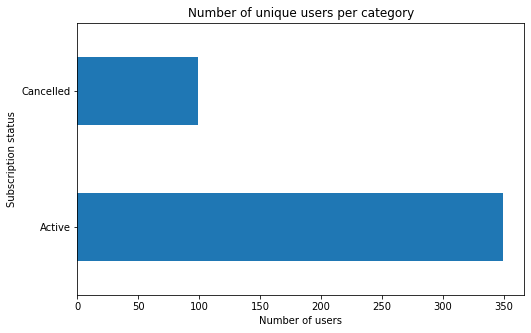

In [15]:
# Plot frequency

def plot_frequency(subset, group, labels, x_title = 'Number of users', y_title='Subscription status'):
    ax = df_pandas.drop_duplicates(subset = subset).groupby(group)['userId'].count().plot(
        kind = 'barh', figsize=(8,5), title='Number of unique users per category')
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_yticklabels(labels, rotation=0)

plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

There is a huge number of cancellation, about 25% of the users cancelled!

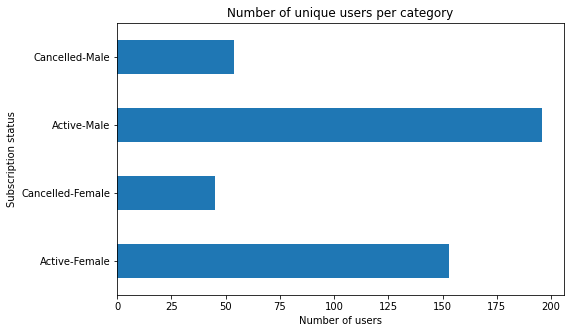

In [16]:
plot_frequency(['userId', 'gender'], ['gender', 'churn'], ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

We see that more male users cancelled than females. Gender may affect churn.

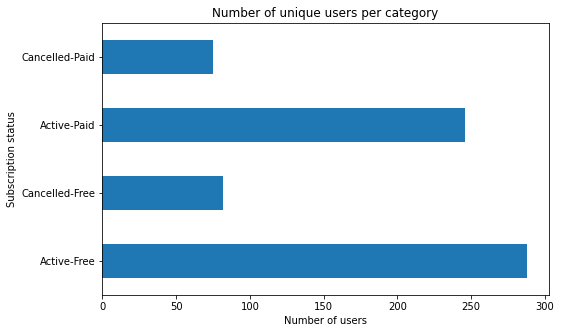

In [17]:
plot_frequency(['userId', 'level'], ['level', 'churn'], ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

Free users cancelled the service slightly more than paid users. Level may impact less than gender on churn.

page
About                         0.959195
Add Friend                    7.969098
Add to Playlist              11.712552
Cancel                        0.513299
Cancellation Confirmation     0.513299
Downgrade                     4.308602
Error                         0.502929
Help                          2.680562
Home                         19.588324
Logout                        6.138850
Roll Advert                  11.334059
Save Settings                 0.539223
Settings                      3.209416
Submit Downgrade              0.150360
Submit Upgrade                0.362939
Thumbs Down                   5.993674
Thumbs Up                    22.294810
Upgrade                       1.228807
Name: userId, dtype: float64


Text(0.5, 1.0, 'Percent of envent occurence for active and cancelled users')

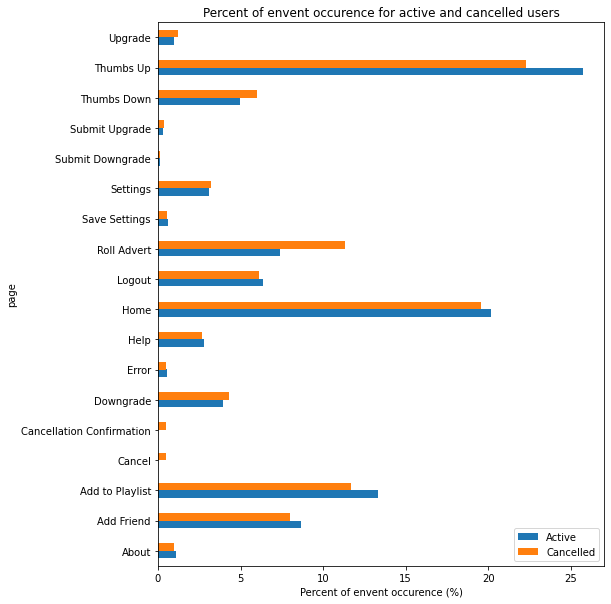

In [18]:
# Check the impact of page types on churn 
user_0 = df_pandas[df_pandas.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
user_0 = 100 * user_0 /user_0.sum()

user_1 = df_pandas[df_pandas.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
user_1 = 100 * user_1 /user_1.sum()

df_users = pd.DataFrame({'Active': user_0, 'Cancelled': user_1})
ax = df_users.plot(kind = 'barh', figsize = (8, 10))
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users')

It looks like people reviewing roll advert are more likely to cancel. Also, thumbs down users are more likely to cancel. 

## Time analysis 

In [19]:
# get hour, day, month, and weekday from timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))


In [20]:
# create columns for hour, day, month, and weekday
funcs = {'hour': get_hour,'day':get_day, 'month':get_month, 'week_day':get_weekday }
for label, func in funcs.items():
    df_data_1 = df_data_1.withColumn(label, func(df_data_1.ts))
    print(f'Column {label} add successfully!')

Column hour add successfully!
Column day add successfully!
Column month add successfully!
Column week_day add successfully!


In [21]:
df_p = df_data_1.toPandas()

In [23]:
df_p.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Sandstorm,200,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Phantom Part 1.5 (Album Version),200,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Canada,200,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Ticket To Ride,200,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Dismissed (Uffie),200,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1


In [22]:
def get_user_time(time, churn):
    '''
    calcuate the percentage of users by time
    '''
    user_time = df_p[df_p.churn == churn].groupby(time)['userId'].count()
    perc_time = 100 * user_time / user_time.sum()
    try:
        perc_time.index = perc_time.index.astype(int)
    except:
        pass
    return perc_time.sort_index()


def plot_time_dist(time, figsize=(15,4), title=None, label_rotation=0):
    '''
    plot time distribution of churn/active users
    '''
    df_time = pd.DataFrame({'Cancelled': get_user_time(time, 1), 'Active': get_user_time(time, 0)})
    ax = df_time.plot(kind='bar', figsize=figsize)
    ax.set_ylabel('Percent of users')
    if title == None:
        title = time
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

<AxesSubplot:title={'center':'Percent of users took action per hour of the day'}, xlabel='hour', ylabel='Percent of users'>

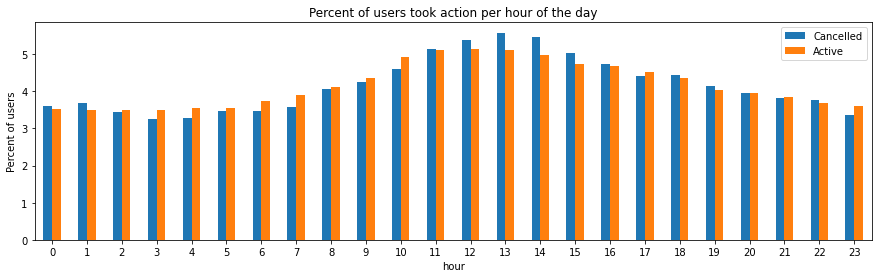

In [23]:
plot_time_dist('hour', title = 'hour of the day')

It looks like the number of active and churn users are pretty close for each hour, except for between 13:00 and 16:00 when more users churn.

<AxesSubplot:title={'center':'Percent of users took action per month'}, xlabel='month', ylabel='Percent of users'>

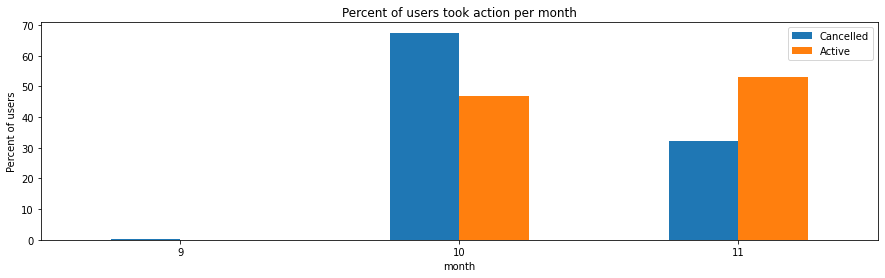

In [24]:
plot_time_dist('month', title = 'month')

Obviously, more users churned in October. Month significantly impacts churn rate.

<AxesSubplot:title={'center':'Percent of users took action per day'}, xlabel='day', ylabel='Percent of users'>

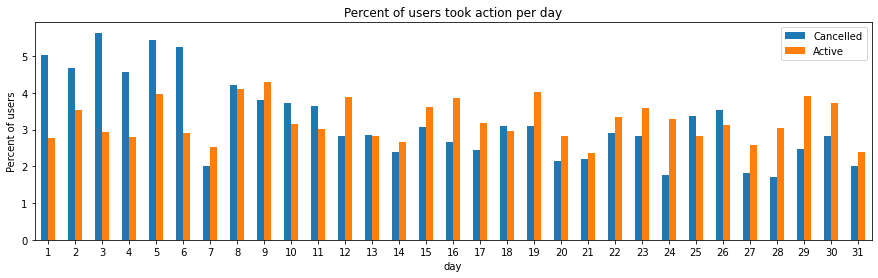

In [25]:
plot_time_dist('day', title = 'day')

More users walked away at the beginning of the month.

[Text(0, 0, 'Mon'),
 Text(1, 0, 'Tue'),
 Text(2, 0, 'Wed'),
 Text(3, 0, 'Thu'),
 Text(4, 0, 'Fri'),
 Text(5, 0, 'Sat'),
 Text(6, 0, 'Sun')]

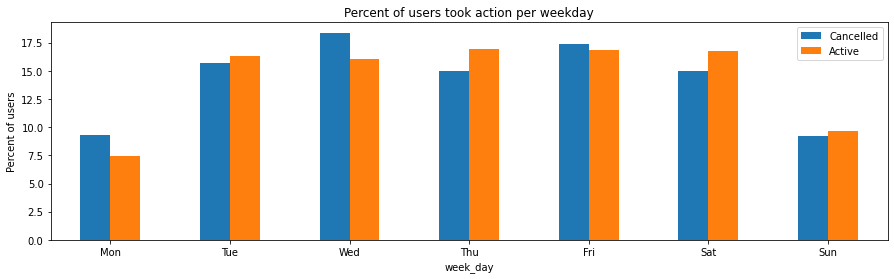

In [26]:
ax = plot_time_dist('week_day', title = 'weekday')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

More churn happened on Mon, Wed, Fri. 

## Check categorical variables

In [27]:
# check unique user agents
df_p.userAgent.unique().shape[0]

71

In [40]:
# get the list of unique user agents
agents = [x.strip() for x  in df_p.userAgent.unique() if x is not None] 

In [43]:
# sort the list of agents
sorted(list(set(x[x.find('(') + 1:x.find(')')].split(';')[0].capitalize() for x in agents)))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [44]:
# Create general categories for user agent
sys_general = {'Compatible': 'Windows', 'Ipad': 'iOS', 'Iphone': 'iOS', 'Macintosh': 'Mac', 
                'Windows nt 5.1': 'Windows','Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows',
                'Windows nt 6.2': 'Windows', 'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

get_sys = udf(lambda x: sys_general[x[x.find('(') + 1:x.find(')')].split(';')[0].capitalize()])
df_data_1 = df_data_1.withColumn('computer_systems', get_sys(df_data_1.userAgent))
df_data_1.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|hour|day|month|week_day|computer_systems|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+
|              Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       62|           Sandstorm|   200|153899

2. Location \
We only consider state.

In [45]:
# get the number of unique states
df_p.location.unique().shape[0]

192

In [47]:
df_p.location.unique()

array(['Bridgeport-Stamford-Norwalk, CT',
       'New York-Newark-Jersey City, NY-NJ-PA',
       'Dallas-Fort Worth-Arlington, TX', 'Denver-Aurora-Lakewood, CO',
       'Providence-Warwick, RI-MA', 'Muncie, IN',
       'Vineland-Bridgeton, NJ', 'Corpus Christi, TX', 'Morgantown, WV',
       'San Francisco-Oakland-Hayward, CA',
       'Chicago-Naperville-Elgin, IL-IN-WI',
       'Lafayette-West Lafayette, IN', 'Seattle-Tacoma-Bellevue, WA',
       'Columbus, GA-AL', 'Boston-Cambridge-Newton, MA-NH',
       'Ottawa-Peru, IL', 'New Orleans-Metairie, LA',
       'Charlotte-Concord-Gastonia, NC-SC',
       'Los Angeles-Long Beach-Anaheim, CA',
       'Allentown-Bethlehem-Easton, PA-NJ', 'Ionia, MI',
       'Detroit-Warren-Dearborn, MI', 'Indianapolis-Carmel-Anderson, IN',
       'Danville, VA', 'Lexington-Fayette, KY',
       'Spokane-Spokane Valley, WA', 'Milwaukee-Waukesha-West Allis, WI',
       'Houston-The Woodlands-Sugar Land, TX', 'Wichita, KS',
       'Miami-Fort Lauderdale-West Pal

In [49]:
# create the column of state
get_state = udf(lambda x: x.split(',')[1].strip())
df_data_1 = df_data_1.withColumn('State', get_state(df_data_1.location))
df_data_1.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|hour|day|month|week_day|computer_systems|State|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+-----+
|              Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       62|           Sands

In [50]:
df_p = df_data_1.toPandas()
df_p.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,churn,hour,day,month,week_day,computer_systems,State
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT


<AxesSubplot:title={'center':'Percent of users took action per computer_systems'}, xlabel='computer_systems', ylabel='Percent of users'>

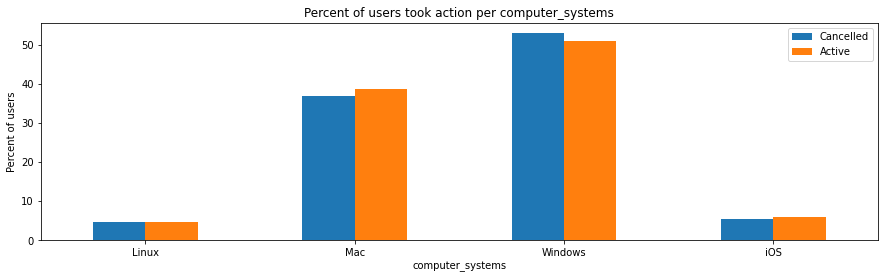

In [52]:
plot_time_dist('computer_systems')

It seems that Mac users are more willing to be active than Windows users, but the impact is not significant visually.

<AxesSubplot:title={'center':'Percent of users took action per State'}, xlabel='State', ylabel='Percent of users'>

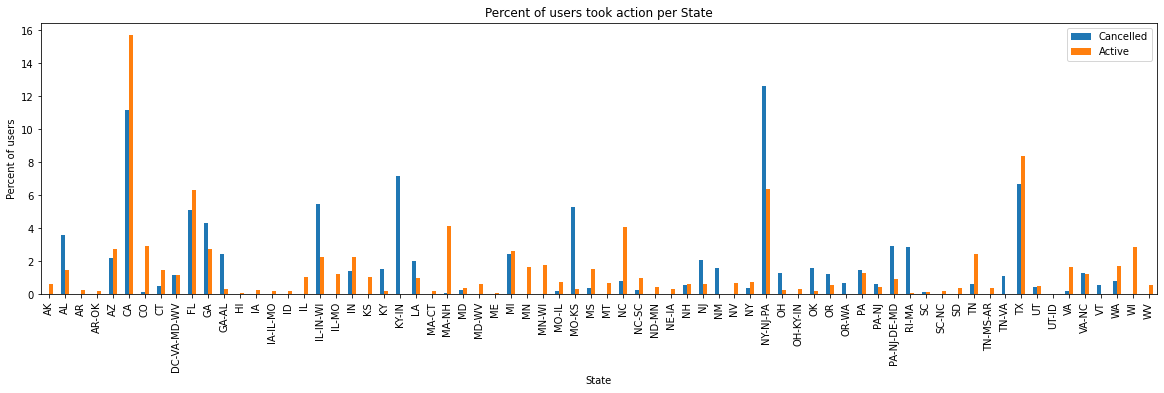

In [55]:
plot_time_dist('State', figsize=(20,5), label_rotation=90)

Based on the state distribution above, location has significant impact on churn rate. 

In [57]:
df_data_1.select('State').distinct().count()

70

# Feature engineering
We have completed data exploratory based on which many features would be kept:

- Gender
- payment level (free and paid)
- Used computer system (userAgent)
- location (State)
- Number of thumbs up/down
- Number of downgrades
- Number of roll advert
- time-related variables: Session duration, user's subscription age, ......

We need to create a user-customized table for the modeling purpose.

In [106]:
# get churn users
churn_users = df_data_1.select('userId', 'churn').dropDuplicates()
churn_users.count()

448

In [100]:
def get_dummy(column, val):
    '''
    convert categorical features to dummy variables.
    The get_dummy func is used to convert 'gender' and 'level' columns to dummy.
    '''
    df_data_2 = df_data_1.select('userId', column).dropDuplicates()
    df = df_data_2.withColumn(f'{column}_num', when(col(column) == val, 1).otherwise(0)).select('userId', col(f'{column}_num').cast('int'))
    print(df.printSchema(), df.show(3))

    return df

In [103]:
# run get_dummy func to convert gender to dummy feature
gender_df = get_dummy('gender', 'M')
gender_df.count()

root
 |-- userId: string (nullable = true)
 |-- gender_num: integer (nullable = false)



+------+----------+
|userId|gender_num|
+------+----------+
|   234|         1|
|   188|         0|
|   273|         1|
+------+----------+
only showing top 3 rows

None None


448

In [235]:
# run get_dummy func to convert level to dummy feature
level_df = get_dummy('level', 'paid')

root
 |-- userId: string (nullable = true)
 |-- level_num: integer (nullable = false)

+------+---------+
|userId|level_num|
+------+---------+
|   185|        0|
|   207|        0|
|     6|        0|
+------+---------+
only showing top 3 rows

None None


In [248]:
# Create dummy variables for computer_systems and state
def dummy_sys_state(column_name):
    '''
    We use this function to convert useragent and state to dummy variables.
    sys_list - the list of unique values
    list_exp - convert categorical features to 0-1 dummy variable
    '''
    sys_list = df_data_1.select(column_name).distinct().rdd.flatMap(lambda x: x).collect()
    list_exp = [when(col(column_name) == x, 1).otherwise(0).alias(x) for x in sys_list]
    df = df_data_1.select('userId', *list_exp).dropDuplicates()
    df.show(10)

    return df

In [249]:
# Create dummy variables for userAgent
sys_df = dummy_sys_state('computer_systems')

+------+---+-----+---+-------+
|userId|iOS|Linux|Mac|Windows|
+------+---+-----+---+-------+
|    57|  0|    0|  1|      0|
|    40|  0|    0|  0|      1|
|   119|  0|    0|  0|      1|
|   221|  1|    0|  0|      0|
|    24|  0|    0|  0|      1|
|   232|  0|    0|  1|      0|
|   212|  0|    0|  0|      1|
|   203|  0|    0|  1|      0|
|     4|  0|    0|  0|      1|
|   263|  0|    0|  1|      0|
+------+---+-----+---+-------+
only showing top 10 rows



In [251]:
# Create dummy variables for state
loc_df = dummy_sys_state('State')
loc_df.count()

+------+---+---+-----+---+---+-----+-----+---+-----+-----+---+-----+-----+-----+---+--------+---+---+---+---+---+---+---+---+---+---+-----+---+-----+---+---+---+---+---+-----+---+---+---+---+---+-----------+---+-----+-----+-----------+---+-----+---+--------+--------+---+-----+---+---+---+-----+---+--------+-----+---+-----+--------+---+---+---+---+-----+---+-----+---+
|userId| AZ| SC|GA-AL| LA| MN|RI-MA|MA-CT| NJ|IL-MO|MN-WI| OR|PA-NJ|SC-NC|MD-WV| VA|NY-NJ-PA| KY| NH| MI| NV| WI| CA| CT| MT| NC| MD|NE-IA| IL|ND-MN| ME| WA| MS| AL| IN|AR-OK| OH| TN| NM| PA| SD|DC-VA-MD-WV| NY|MO-KS|KY-IN|PA-NJ-DE-MD| TX|VA-NC| GA|IL-IN-WI|OH-KY-IN| KS|MO-IL| FL| CO| AK|MA-NH| OK|TN-MS-AR|TN-VA| UT|NC-SC|IA-IL-MO| IA| WV| ID| VT|OR-WA| AR|UT-ID| HI|
+------+---+---+-----+---+---+-----+-----+---+-----+-----+---+-----+-----+-----+---+--------+---+---+---+---+---+---+---+---+---+---+-----+---+-----+---+---+---+---+---+-----+---+---+---+---+---+-----------+---+-----+-----+-----------+---+-----+---+--------+--

448

In [120]:
loc_df.dropDuplicates().count()

448

**Number of page events**

In [187]:
# To get the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...
# I think it is better to get all actions except Chorn actions (Cancel, cancelation confirmation)
# The to normalize them as percent to sum all to 100.

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df_data_1.groupby('userId').pivot('page').count().na.fill(0) 
# Drop Cancel	Cancellation Confirmation columns
drop_col = ['Cancel', 'Cancellation Confirmation']
user_page_distribution = user_page_distribution.drop(*drop_col)
user_page_distribution.show()

+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|   296|    0|         2|              3|        1|    0|   2|   7|     3|     112|          9|            0|       1|               0|             1|          0|        8|      1|
|100010|    0|         3|              1|        0|    0|   0|   3|     1|      96|         22|            0|       0|               0|             0|          3|        4|      2|
|200002|    1|         2|              6|        3|    0|   1|  23|    11|     310|         11|

In [188]:
# Normalize each row sum to 1

# the columns to be summed and add a total column
page_cols = user_page_distribution.columns[1:]
old_col_names = user_page_distribution.columns
user_page_distribution = user_page_distribution.withColumn('rowsum', p.sum([col(c) for c in page_cols]))
# Apply normalization per column
for c in page_cols:
    user_page_distribution = user_page_distribution.withColumn(f'{c}_norm', col(c)/col('rowsum')*100)
# Remove the total column  
user_page_distribution = user_page_distribution.drop(*page_cols)
user_page_distribution = user_page_distribution.drop('rowsum')

# Rename the normalized columns back
new_col_names = user_page_distribution.columns
for idx in range(len(old_col_names)):
    user_page_distribution = user_page_distribution.withColumnRenamed(new_col_names[idx], old_col_names[idx])


In [190]:
user_page_distribution.toPandas().head()

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,296,0.000000,1.333333,2.000000,0.666667,0.0,1.333333,4.666667,2.000000,74.666667,6.000000,0.000000,0.666667,0.0,0.666667,0.000000,5.333333,0.666667
1,100010,0.000000,2.222222,0.740741,0.000000,0.0,0.000000,2.222222,0.740741,71.111111,16.296296,0.000000,0.000000,0.0,0.000000,2.222222,2.962963,1.481481
2,200002,0.254453,0.508906,1.526718,0.763359,0.0,0.254453,5.852417,2.798982,78.880407,2.798982,0.000000,0.508906,0.0,0.254453,1.272265,3.816794,0.508906
3,125,0.000000,3.571429,2.380952,0.000000,0.0,2.380952,2.380952,0.000000,73.809524,7.142857,0.000000,3.571429,0.0,0.000000,1.190476,3.571429,0.000000
4,124,0.139276,1.207057,2.089136,0.974930,0.0,0.464253,3.249768,0.789229,84.772516,0.046425,0.139276,0.696379,0.0,0.000000,0.696379,4.735376,0.000000


**Number of artist the user likes**

In [191]:
artists = df_data_1.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed('count', 'num_artist')
artists.show()

+------+----------+
|userId|num_artist|
+------+----------+
|   296|       109|
|100010|        95|
|200002|       288|
|   125|        62|
|   124|      1241|
|    51|       234|
|     7|       408|
|200037|       115|
|   205|       804|
|   169|       112|
|   272|        94|
|    54|       439|
|   234|      1174|
|   282|      1642|
|   232|      1281|
|    15|      1287|
|   155|       134|
|200043|       513|
|   132|       107|
|   154|        93|
+------+----------+
only showing top 20 rows



**Session Duration**

In [197]:
# get the duration of each session for each user
start = df_data_1.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
end = df_data_1.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
sesseion_duration = start.join(end, ['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = sesseion_duration.select('userId', 'sessionId', ((col('end')-col('start'))/ticks_per_hours).alias('session_duration (h)'))
session_df.show(5)

+------+---------+--------------------+
|userId|sessionId|session_duration (h)|
+------+---------+--------------------+
|    77|      343|  10.395277777777778|
|    39|      904|              3.9525|
|   137|      136|  3.2683333333333335|
|   273|      520|   3.100277777777778|
|   127|     1067|  12.248888888888889|
+------+---------+--------------------+
only showing top 5 rows



In [201]:
# calcuate the mean and std of session duration for each user
user_session_hr = session_df.groupBy('userId').agg(avg('session_duration (h)').alias('mean_duration'), stddev('session_duration (h)').alias('std_duration')).na.fill(0)
user_session_hr.show(5)

+------+------------------+------------------+
|userId|     mean_duration|      std_duration|
+------+------------------+------------------+
|   296|1.6172777777777774|1.4737091207327395|
|100010|3.5062499999999996|0.2873603391321997|
|200002| 4.384333333333333|2.9375948802643896|
|   125| 1.416388888888889| 1.892293418768889|
|    51| 3.661388888888889| 4.110719111378728|
+------+------------------+------------------+
only showing top 5 rows



**Session Count**

In [202]:
# get the number of session for each user
session_count = df_data_1.select('userId', 'sessionId').dropDuplicates().groupBy('userId').count().withColumnRenamed('count', 'num_sessions')
session_count.show()

+------+------------+
|userId|num_sessions|
+------+------------+
|   296|           5|
|100010|           2|
|200002|           5|
|   125|           3|
|    51|           5|
|     7|          15|
|   124|          17|
|200037|           7|
|   205|           5|
|   169|           8|
|   272|           2|
|    54|           8|
|   232|          23|
|   282|          29|
|   234|          26|
|    15|          18|
|   155|           4|
|200043|          12|
|   154|           4|
|   132|           2|
+------+------------+
only showing top 20 rows



**The user's subscription duration**

In [203]:
def subscription_age(df_data_1, col_name):
    '''
    This function is used to calculate the duration of each user being active.
    '''
    # timestamp of users registration
    reg_time = df_data_1.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'registration_time')
    # The maximum timestamp found for the user
    max_time = df_data_1.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'current')
    reg_df = reg_time.join(max_time, 'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.current - reg_df.registration_time)/ticks_per_day).alias(col_name))

    return reg_df

In [204]:
# create a subscription_age column
reg_df = subscription_age(df_data_1, 'subscription_age')
reg_df.show(5)

+------+------------------+
|userId|  subscription_age|
+------+------------------+
|   296| 26.63826388888889|
|   125|105.42211805555556|
|    51| 18.84582175925926|
|   124| 112.5537962962963|
|     7| 78.02979166666667|
+------+------------------+
only showing top 5 rows



**Collect all to prepare the dataset for modeling**

In [349]:
# collect all features to join in one table
features = [gender_df, level_df, sys_df, loc_df, user_page_distribution, artists, user_session_hr, session_count, reg_df]
# initialize the joined table
new_df = churn_users
# join each feature to the modeling dataset
for i, feature in enumerate(features):
    new_df = new_df.join(feature, 'userId', how = 'inner')
    print(f"the new frame's dimensions is: {new_df.count()} * {len(new_df.columns)}")

final_df = new_df.orderBy('userId', ascending = True)
print('*** Dataset is ready! ***')

the new frame's dimensions is: 448 * 3


the new frame's dimensions is: 691 * 4


the new frame's dimensions is: 691 * 8


the new frame's dimensions is: 691 * 78


the new frame's dimensions is: 691 * 95


the new frame's dimensions is: 691 * 96


the new frame's dimensions is: 691 * 98


the new frame's dimensions is: 691 * 99


the new frame's dimensions is: 691 * 100
*** Dataset is ready! ***


**Save data to local**

In [351]:
# save the final dataset locally
final_df.write.csv('churn_model_data.csv', header = True)

# Modeling
In this section, we will split dataset into train, valid, and test sets. Try different machine learning methods including:

- Logistic Regression
- Decision Tree Classifier
- Gradient Boosting Trees (GBTs)
- Random Forest
- Multilayer Perceptron Classifier

## 1. Load training data

In [559]:
import time
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from sklearn.inspection import permutation_importance
from pyspark.ml.feature import VectorAssembler, StandardScaler
from sklearn.metrics import f1_score
from pyspark.sql.types import IntegerType, FloatType

In [353]:
# load the saved modeling dataset
final_df = spark.read.csv('churn_model_data.csv', header=True)
final_df.show(1)

+------+-----+----------+---------+---+-----+---+-------+---+---+-----+---+---+-----+-----+---+-----+-----+---+-----+-----+-----+---+--------+---+---+---+---+---+---+---+---+---+---+-----+---+-----+---+---+---+---+---+-----+---+---+---+---+---+-----------+---+-----+-----+-----------+---+-----+---+--------+--------+---+-----+---+---+---+-----+---+--------+-----+---+-----+--------+---+---+---+---+-----+---+-----+---+-----+------------------+----------------+-------------------+-------------------+------------------+------------------+------------------+----------------+-----------+-------------+------------------+----------------+--------------+-------------------+-----------------+-------+----------+-------------+------------+------------+------------------+
|userId|churn|gender_num|level_num|iOS|Linux|Mac|Windows| AZ| SC|GA-AL| LA| MN|RI-MA|MA-CT| NJ|IL-MO|MN-WI| OR|PA-NJ|SC-NC|MD-WV| VA|NY-NJ-PA| KY| NH| MI| NV| WI| CA| CT| MT| NC| MD|NE-IA| IL|ND-MN| ME| WA| MS| AL| IN|AR-OK| OH| TN|

In [354]:
# replace space in column names with underscore
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('-', '_'))
print(final_df.columns)

['userId', 'churn', 'gender_num', 'level_num', 'iOS', 'Linux', 'Mac', 'Windows', 'AZ', 'SC', 'GA_AL', 'LA', 'MN', 'RI_MA', 'MA_CT', 'NJ', 'IL_MO', 'MN_WI', 'OR', 'PA_NJ', 'SC_NC', 'MD_WV', 'VA', 'NY_NJ_PA', 'KY', 'NH', 'MI', 'NV', 'WI', 'CA', 'CT', 'MT', 'NC', 'MD', 'NE_IA', 'IL', 'ND_MN', 'ME', 'WA', 'MS', 'AL', 'IN', 'AR_OK', 'OH', 'TN', 'NM', 'PA', 'SD', 'DC_VA_MD_WV', 'NY', 'MO_KS', 'KY_IN', 'PA_NJ_DE_MD', 'TX', 'VA_NC', 'GA', 'IL_IN_WI', 'OH_KY_IN', 'KS', 'MO_IL', 'FL', 'CO', 'AK', 'MA_NH', 'OK', 'TN_MS_AR', 'TN_VA', 'UT', 'NC_SC', 'IA_IL_MO', 'IA', 'WV', 'ID', 'VT', 'OR_WA', 'AR', 'UT_ID', 'HI', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'num_artist', 'mean_duration', 'std_duration', 'num_sessions', 'subscription_age']


In [358]:
# change string userId to numeric
final_df = final_df.withColumn('userId', final_df.userId.cast(IntegerType()))
final_df = final_df.withColumn('churn', final_df.churn.cast(IntegerType()))

for col in final_df.columns[2:80]:
    final_df = final_df.withColumn(col, final_df[col].cast(IntegerType()))
final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender_num: integer (nullable = true)
 |-- level_num: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- Linux: integer (nullable = true)
 |-- Mac: integer (nullable = true)
 |-- Windows: integer (nullable = true)
 |-- AZ: integer (nullable = true)
 |-- SC: integer (nullable = true)
 |-- GA_AL: integer (nullable = true)
 |-- LA: integer (nullable = true)
 |-- MN: integer (nullable = true)
 |-- RI_MA: integer (nullable = true)
 |-- MA_CT: integer (nullable = true)
 |-- NJ: integer (nullable = true)
 |-- IL_MO: integer (nullable = true)
 |-- MN_WI: integer (nullable = true)
 |-- OR: integer (nullable = true)
 |-- PA_NJ: integer (nullable = true)
 |-- SC_NC: integer (nullable = true)
 |-- MD_WV: integer (nullable = true)
 |-- VA: integer (nullable = true)
 |-- NY_NJ_PA: integer (nullable = true)
 |-- KY: integer (nullable = true)
 |-- NH: integer (nullable = true)
 |-- MI: integer (nulla

In [378]:
# Replace nulls with 0
final_df = final_df.na.fill(0)
final_df.show(2)

+------+-----+----------+---------+---+-----+---+-------+---+---+-----+---+---+-----+-----+---+-----+-----+---+-----+-----+-----+---+--------+---+---+---+---+---+---+---+---+---+---+-----+---+-----+---+---+---+---+---+-----+---+---+---+---+---+-----------+---+-----+-----+-----------+---+-----+---+--------+--------+---+-----+---+---+---+-----+---+--------+-----+---+-----+--------+---+---+---+---+-----+---+-----+---+-----+----------+---------------+---------+-----------+---------+---------+----------+---------+-----------+-------------+---------+----------------+--------------+-----------+---------+-----------+----------+-------------+------------+------------+----------------+
|userId|churn|gender_num|level_num|iOS|Linux|Mac|Windows| AZ| SC|GA_AL| LA| MN|RI_MA|MA_CT| NJ|IL_MO|MN_WI| OR|PA_NJ|SC_NC|MD_WV| VA|NY_NJ_PA| KY| NH| MI| NV| WI| CA| CT| MT| NC| MD|NE_IA| IL|ND_MN| ME| WA| MS| AL| IN|AR_OK| OH| TN| NM| PA| SD|DC_VA_MD_WV| NY|MO_KS|KY_IN|PA_NJ_DE_MD| TX|VA_NC| GA|IL_IN_WI|OH_KY_IN

In [454]:
# Collect features using VectorAssembler
feature_labels = final_df.columns[2:]
assembler = VectorAssembler(inputCols=feature_labels, outputCol='features')
input = assembler.transform(final_df)
input.select('features').show(10)

+--------------------+
|            features|
+--------------------+
|(98,[0,1,4,37,78,...|
|(98,[0,5,51,77,78...|
|(98,[0,1,5,51,77,...|
|(98,[4,58,78,81,8...|
|(98,[1,5,27,78,79...|
|(98,[5,27,78,79,8...|
|(98,[1,5,58,78,79...|
|(98,[5,58,78,79,8...|
|(98,[5,47,77,78,8...|
|(98,[0,4,9,78,82,...|
+--------------------+
only showing top 10 rows



In [455]:
# Scale the features
feature_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
scaler_fit = feature_scaler.fit(input)
scaled_input = scaler_fit.transform(input)
model_data = scaled_input.select(scaled_input.churn.alias('label'), scaled_input.scaled_features.alias('features'))
model_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.89611034902926...|
|    0|[0.89611034902926...|
|    0|[0.89611034902926...|
|    1|[-1.1143190379162...|
|    0|[-1.1143190379162...|
+-----+--------------------+
only showing top 5 rows



In [456]:
# split the dataset into training and testing sets
train, test = model_data.randomSplit([0.9, 0.1], seed = 42)

## 2. Train and test model

In [535]:

def model_fit(data, model_type, param_grid, save_model, num_folds=10, random_seed=42):
    '''
    This function is used to fit the defined model.
    cross_val - model cross validation
    model_type - the type of model we used which includ logistic regression, decision tree, gradient boosting, random forest, and multiperception layer
    param_grid - the search window of hyperparameters
    evaluator - the type of evaluation metrics
    numFolds - the number of cross validation folds
    '''
    cross_val = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid, \
                            evaluator=MulticlassClassificationEvaluator(), numFolds=num_folds, seed=random_seed)
    
    start = time.time()
    model = cross_val.fit(data)      
    training_duration = time.time() - start
    print("training time is {}s".format(training_duration))

    try:
        model.save(save_model)  
    except:
        model.write().overwrite().save(save_model)

    return model    


def get_metrics(metrics):
    '''
    This function is used to get metrics of training model.
    acc - model accuracy
    general_score - the general precision, recall, and f1 score for all users (churn = 0 or 1)
    label_score - the score for active or churn users respectively
    '''
    acc = metrics.accuracy
    general_score = np.array((metrics.weightedFMeasure(), metrics.weightedPrecision, metrics.weightedRecall,
                              metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
    general_score = general_score.reshape(1, general_score.shape[0])
    labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
    label_score = np.array((metrics.fMeasureByLabel(), metrics.precisionByLabel, metrics.recallByLabel,
                            metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))

    concat_results = np.concatenate((general_score.T, label_score), axis=1)
    metrics_name = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
    df = pd.DataFrame(concat_results, columns = labels, index=metrics_name)

    return acc, df


def model_testing(test_data, model):
    '''
    this function is used to get testing performance.
    metrics_train - the metrics with respect to training
    train_acc, train_score - training performance 
    metrics_test - the metrics with respect to testing
    test_acc, test_score - testing performance
    '''
    metrics_train = model.bestModel.summary
    train_acc, train_score = get_metrics(metrics_train)

    label_predictions = model.bestModel.evaluate(test_data)
    metrics_test = label_predictions
    test_acc, test_score = get_metrics(metrics_test)

    # Concatenate training and testing score
    con_df = pd.concat([train_score, test_score], axis=1, keys=[
        f'Training Accuracy = {train_acc*100:4.2f}%',
        f'Testing Accuracy = {test_acc*100:4.2f}%'
    ])

    return con_df


def draw_features_contribution(model, x_labels):
    '''
    this function is to plot feature importance.
    coeffs - the coefficients of the best model
    positive_coeffs, negative_coeffs - positive and neagative coefficients (perct)
    '''
    coeffs = model.bestModel.coefficientMatrix
    coeffs = coeffs.values

    positive_coeffs = np.array([x if x >= 0 else 0 for x in coeffs])
    negative_coeffs = np.array([x if x <= 0 else 0 for x in coeffs])

    coeffs_sum = positive_coeffs.sum() + np.absolute(negative_coeffs).sum()
    positive_coeffs /= coeffs_sum
    negative_coeffs /= coeffs_sum
    positive_coeffs *= 100
    negative_coeffs *= 100

    fig, ax = plt.subplots(figsize=(20, 9))
    ax.bar(x_labels, positive_coeffs,color='r')
    ax.bar(x_labels, negative_coeffs, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = x_labels, rotation='vertical')


def compute_classifier_metrics(data, model, label):
    '''
    This function is used to compute classifier metrics given that the other four methods (except for logistic regression) do not have the bestModel.coefficientMatrix class.
    pred - the dataframe containing real label and its model prediction
    true_prositive, false_positive, false_negative - the score used to calculate precision, recall, and f1
    '''
    pred = model.transform(data).select('label', 'prediction')
    true_positive = pred.filter((pred.label == 1) & (pred.label == pred.prediction)).count()
    false_positive = pred.filter((pred.label == 0) & (pred.label != pred.prediction)).count()
    false_negative = pred.filter((pred.label == 1) & (pred.label != pred.prediction)).count()
    accuracy = pred.filter(pred.label == pred.prediction).count() / pred.count() * 100
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2*precision*recall / (precision + recall)
    labels = [label]
    idx = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    df = pd.DataFrame(np.array([accuracy, precision, recall, f1]), columns=labels, index=idx)

    return df


def get_classifier_metrics(train, test, model):
    '''
    compute metrics of classifiers
    '''
    train_score_df = compute_classifier_metrics(train, model, 'Train')
    test_score_df = compute_classifier_metrics(test, model, 'Test')
    metrics_df = pd.concat([train_score_df, test_score_df], axis = 1)

    return metrics_df


def draw_classifier_feature_importance(model, xlabels, threshold):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(model.bestModel.featureImportances.toArray())

    # get the accepted indexes
    keep_features = [x for x in importance if x >= threshold/100]
    idx = [importance.index(x) for x in keep_features]
    features_label = [xlabels[x] for x in idx]

    # sorting
    features_label =[x for _, x in sorted(zip(keep_features, features_label))]
    keep_features = sorted(keep_features)

    # Draw
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(keep_features[::-1], labels=features_label[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90)
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal')


**Logistic Regression**

In [574]:
# Logistic Regressions
model = LogisticRegression()
param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.01, 0.1]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5]) \
            .build()

fit_model = model_fit(train, model, param_grid, 'LogisticRegression.model')
features_label = final_df.columns[2:]

training time is 107.42682480812073s


In [575]:
# model metrics
model_testing(test, fit_model)

Training Accuracy = 86.99%                      \
                                  General Churn=0.0 Churn=1.0   
F-Measure                        0.858254  0.920115  0.649789   
Precision                        0.867518  0.873857  0.846154   
Recall                           0.869906  0.971545  0.527397   
True_+ve_Rate                    0.869906  0.971545  0.527397   
False_+ve_Rate                   0.370964  0.472603  0.028455   

               Testing Accuracy = 86.79%                      
                                 General Churn=0.0 Churn=1.0  
F-Measure                       0.842187  0.923077  0.533333  
Precision                       0.886792  0.857143  1.000000  
Recall                          0.867925  1.000000  0.363636  
True_+ve_Rate                   0.867925  1.000000  0.363636  
False_+ve_Rate                  0.504288  0.636364  0.000000

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_76398/3699032736.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = x_labels, rotation='vertical')


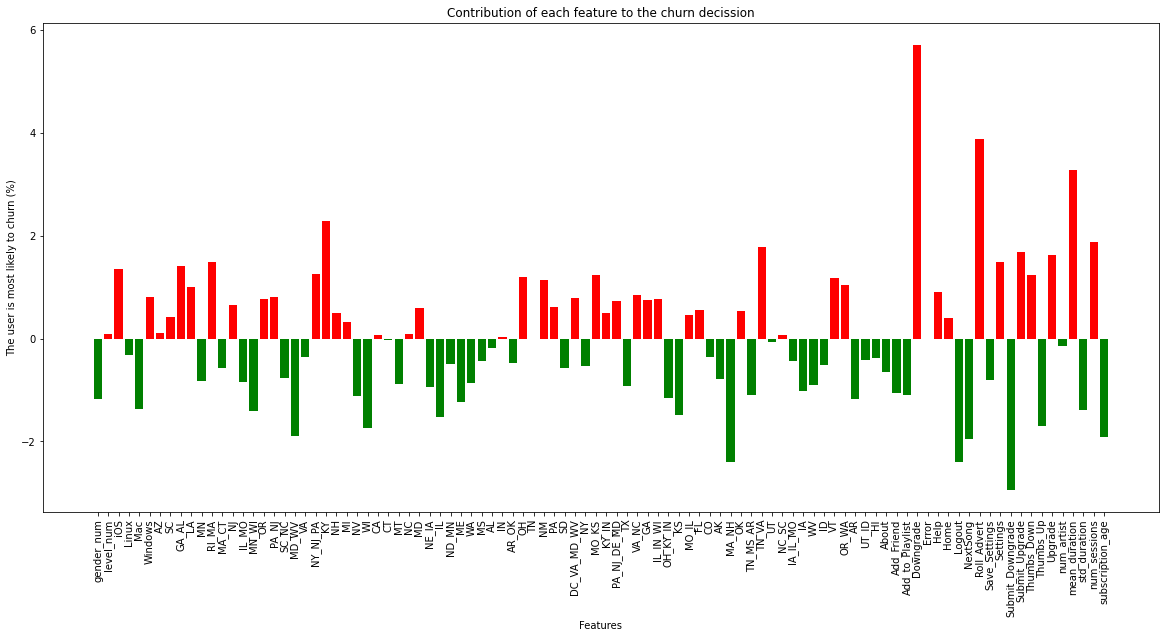

In [487]:
# features effect
draw_features_contribution(fit_model, features_label)

**Decision Tree Classifier**

In [566]:
model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.impurity,['entropy', 'gini']) \
            .build()

fit_model = model_fit(train, model, param_grid, 'DecisionTreeClassifier.model')
features_label = final_df.columns[2:]


training time is 73.41649889945984s


In [567]:
# load model
fit_model = CrossValidatorModel.load('DecisionTreeClassifier.model')

In [568]:
# show metrics
get_classifier_metrics(train, test, fit_model)

,Train,Test
Accuracy,98.589342,94.339623
Precision,1.000000,1.000000
Recall,0.938356,0.727273
F-Score,0.968198,0.842105


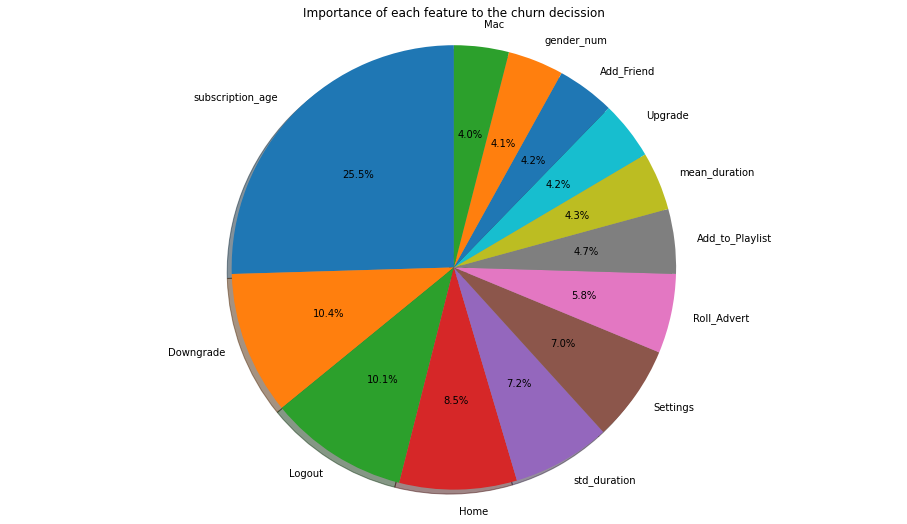

In [569]:
# feature effect
draw_classifier_feature_importance(fit_model, features_label, threshold = 3)

**Gradient Boost Tree**

In [512]:

model = GBTClassifier()
param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.maxBins,[5, 10]) \
            .addGrid(model.maxIter, [5, 10]) \
            .build()

fit_model = model_fit(train, model, param_grid, 'GradientBoostedTrees.model')
features_label = final_df.columns[2:]

training time is 257.276487827301s


In [ ]:
# load model
fit_model = CrossValidatorModel.load('GradientBoostedTrees.model')

In [513]:
# show metrics
get_classifier_metrics(train, test, fit_model)

,Train,Test
Accuracy,100.0,90.566038
Precision,1.0,0.800000
Recall,1.0,0.727273
F-Score,1.0,0.761905


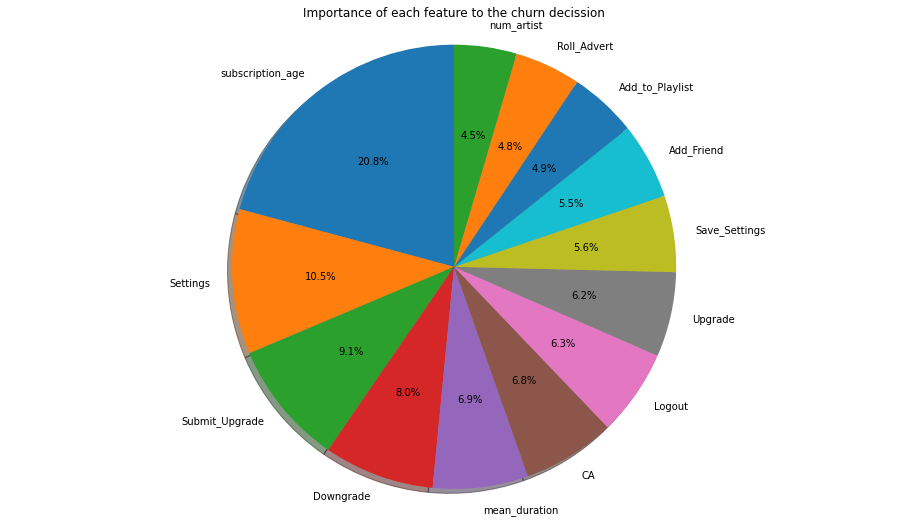

In [536]:
# feature effect
draw_classifier_feature_importance(fit_model, features_label, threshold = 3)

**Random Forest Model**

In [543]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.maxBins,[5, 10]) \
            .addGrid(model.numTrees, [5, 10]) \
            .build()

fit_model = model_fit(train, model, param_grid, 'RandomForestClassifier.model')
features_label = final_df.columns[2:]

training time is 197.3172471523285s


In [ ]:
# load model
fit_model = CrossValidatorModel.load('RandomForestClassifier.model')

In [544]:
# show metrics
get_classifier_metrics(train, test, fit_model)

,Train,Test
Accuracy,94.984326,88.679245
Precision,0.991379,1.000000
Recall,0.787671,0.454545
F-Score,0.877863,0.625000


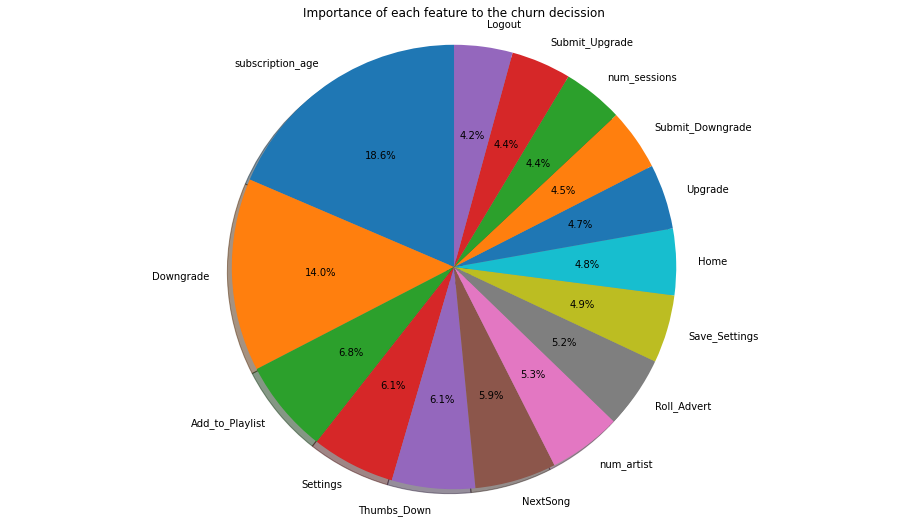

In [545]:
# feature effect
draw_classifier_feature_importance(fit_model, features_label, threshold = 3)

**The Multilayer Perceptron Classifier model**

In [554]:
model = MultilayerPerceptronClassifier()

param_grid = ParamGridBuilder() \
    .addGrid(model.blockSize, [64]) \
    .addGrid(model.maxIter, [10, 20]) \
    .addGrid(model.layers, [[98, 12, 2], [98, 5, 2]]) \
    .addGrid(model.stepSize, [0.03]) \
    .build()

fit_model = model_fit(train, model, param_grid, 'MultilayerPerceptronClassifier.model')

training time is 94.12883615493774s


In [ ]:
# load model
fit_model = CrossValidatorModel.load('MultilayerPerceptronClassifier.model')

In [557]:
# show effect
get_classifier_metrics(train, test, fit_model)

,Train,Test
Accuracy,96.394984,88.679245
Precision,0.912752,0.777778
Recall,0.931507,0.636364
F-Score,0.922034,0.700000


In [556]:
# feature effect
# 'MultilayerPerceptronClassificationModel' object has no attribute 'featureImportances'
draw_classifier_feature_importance(fit_model, features_label, threshold = 3)

AttributeError: 'MultilayerPerceptronClassificationModel' object has no attribute 'featureImportances'